In [114]:
# basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# preprocessing imports
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [115]:
df_train = pd.read_parquet(
    "https://lab.cs307.org/wine/data/wine-train.parquet",
)
df_test = pd.read_parquet(
    "https://lab.cs307.org/wine/data/wine-test.parquet",
)

df_train.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white


In [116]:
df_train['quality'].value_counts()

quality
6    1810
5    1385
7     686
4     133
8     122
3      19
9       2
Name: count, dtype: int64

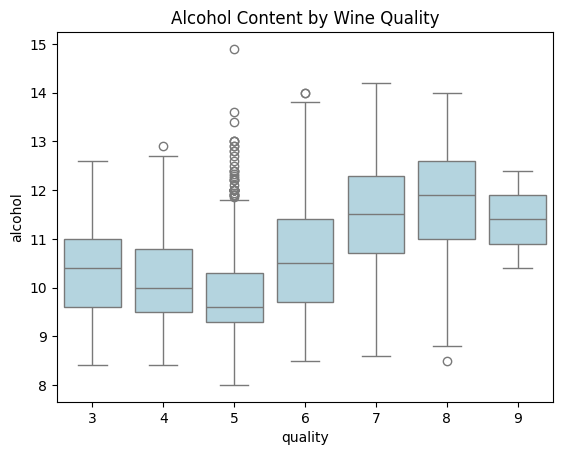

In [117]:
sns.boxplot(x='quality', y='alcohol', data=df_train, color="lightblue")
plt.title('Alcohol Content by Wine Quality')
plt.show()

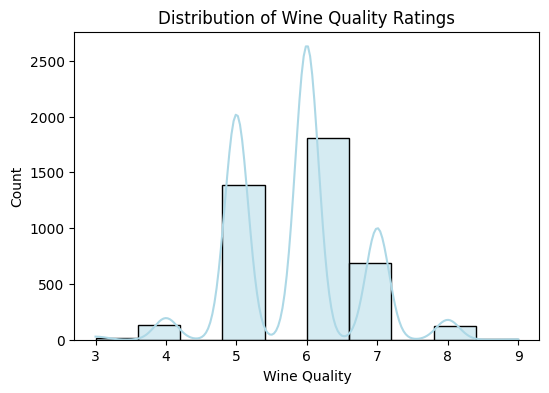

In [118]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["quality"], bins=10, kde=True, color="lightblue")
plt.xlabel("Wine Quality")
plt.ylabel("Count")
plt.title("Distribution of Wine Quality Ratings")
plt.show()

In [119]:
# splitting the train data into train and validation sets
df_vtrain, df_vtest = train_test_split(
    df_train,
    test_size=0.20,
    random_state=42,
)

X_train = df_vtrain.drop("quality", axis=1)
y_train = df_vtrain["quality"]

X_vtest = df_vtest.drop("quality", axis=1)
y_vtest = df_vtest["quality"]


# seperating the final test set
X_test = df_test.drop("quality", axis=1)
y_test = df_test["quality"]

In [120]:
# preprocessing the data (scaling, imputing, encoding)
numeric_features = ["fixed acidity", "volatile acidity", "citric acid", 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
categorical_features = ["color"]
features = numeric_features + categorical_features
target = "quality"


numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    remainder="drop",
)

In [121]:
# fitting the Decision Tree models
mae_scores = []
param_grid = range(1, 16, 1)

for k in param_grid:
    dtree_mod = make_pipeline(
        preprocessor,
        DecisionTreeRegressor(max_depth = k, random_state = 42),
    )
    dtree_mod.fit(X_train, y_train)
    y_pred = dtree_mod.predict(X_vtest)
    mae_scores.append(mean_absolute_error(y_vtest, y_pred))
    
decisiontree_mae = pd.DataFrame(
    {
        "max_depth": param_grid,
        "MAE": mae_scores,
    }
)

In [122]:
# fitting the KNN models
mae_scores = []
param_grid = range(1, 16, 1)

for k in param_grid:
    knn_mod = make_pipeline(
        preprocessor,
        KNeighborsRegressor(n_neighbors = k),
    )
    knn_mod.fit(X_train, y_train)
    y_pred = knn_mod.predict(X_vtest)
    mae_scores.append(mean_absolute_error(y_vtest, y_pred))

knn_mae = pd.DataFrame(
    {
        "neighbors": param_grid,
        "MAE": mae_scores,
    }
)

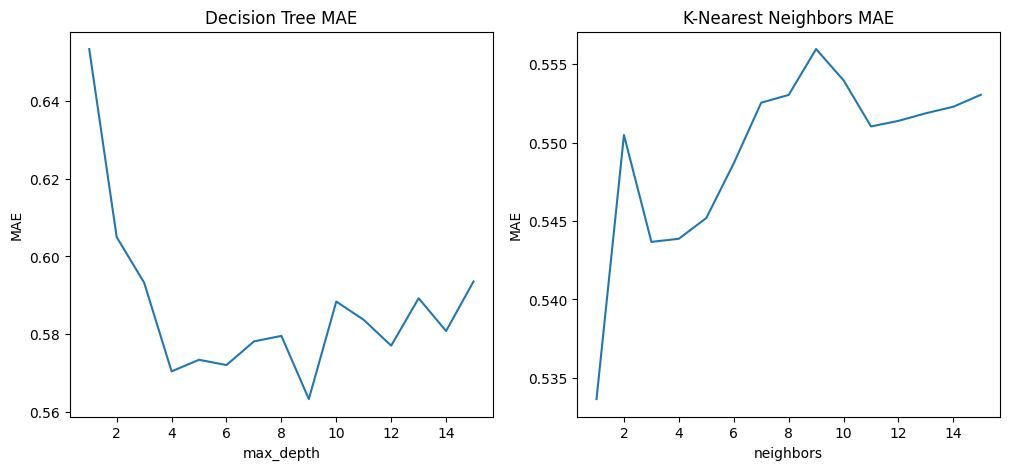

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=decisiontree_mae,x='max_depth',y='MAE', ax=ax1).set_title('Decision Tree MAE')
sns.lineplot(data=knn_mae,x='neighbors',y='MAE', ax=ax2).set_title('K-Nearest Neighbors MAE')
plt.show()

In [124]:
# fitting the Linear Regression model
linear_mod = make_pipeline(
        preprocessor,
        LinearRegression()
)
linear_mod.fit(X_train, y_train)
y_pred = linear_mod.predict(X_test)
linear_mae = mean_absolute_error(y_test, y_pred)
linear_mae

0.5977445162259616

In [125]:
tree_mod = make_pipeline(
        preprocessor,
        DecisionTreeRegressor(max_depth = 20, random_state = 42)
)
tree_mod.fit(X_train, y_train)
y_pred = tree_mod.predict(X_test)
tree_mae = mean_absolute_error(y_test, y_pred)
tree_mae

0.5472513269388269

In [126]:
# fitting the Dummy model
dummy_mod = make_pipeline(
        preprocessor,
        DummyRegressor()
)
dummy_mod.fit(X_train, y_train)
y_pred = dummy_mod.predict(X_test)
dummy_mae = mean_absolute_error(y_test, y_pred)
dummy_mae

0.7149378253325621

In [127]:
# refitting our best performing model on the original test set
knn = make_pipeline(
        preprocessor,
        KNeighborsRegressor(n_neighbors = 1)
)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_mae = mean_absolute_error(y_test, y_pred)
knn_mae

0.5288461538461539

In [128]:
knn_improvement = ((dummy_mae - knn_mae) / dummy_mae) * 100
linear_improvement = ((dummy_mae - linear_mae) / dummy_mae) * 100
tree_improvement = ((dummy_mae - tree_mae) / dummy_mae) * 100

In [129]:
print("K-Nearest Neighbors Model Improvement over baseline model: " + str(round(knn_improvement, 2)) + "%")
print("Decision Tree Model Improvement over baseline model: " + str(round(tree_improvement, 2)) + "%")
print("Linear Regression Model Improvement over baseline model: " + str(round(linear_improvement, 2)) + "%")

K-Nearest Neighbors Model Improvement over baseline model: 26.03%
Decision Tree Model Improvement over baseline model: 23.45%
Linear Regression Model Improvement over baseline model: 16.39%
